# Statistical Analysis

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import scipy.stats as stats
from scipy.stats import shapiro, f_oneway
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)

font = {'fontname': 'Times New Roman', 'fontsize': 12}
tfont = {'fontname': 'Times New Roman', 'fontsize': 14, 'fontweight': 'bold'}

In [2]:
def contains_terminal_marks(text):
    if '.' in text or '!' in text or '?' or '...' in text:
        return True
    return False

In [3]:
data = pd.read_csv('CompMeasures.tsv', sep='\t')
print(data.shape)
data.head(3)

(49397, 38)


C:\Users\Елизавета Клыкова\AppData\Local\Temp\ipykernel_19380\3822152284.py:1: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('CompMeasures.tsv', sep='\t')


corpus language speaker_type language_background  \
0   actr  russian           L1                 NaN   
1   actr  russian           L1                 NaN   
2   actr  russian           L1                 NaN   

                                                text  \
0  Прокатившись по многим городам и странам за по...   
1  В моей жизни я встречала много разных людей. У...   
2  В прошлем году, я провела четыре месяцев в Лон...   

                                       spell_checked  \
0  Прокатившись по многим городам и странам за по...   
1  В моей жизни я встречала много разных людей. У...   
2  В прошлом году, я провела четыре месяцев в Лон...   

                                           annotated  mark       level  \
0  # generator = UDPipe 2, https://lindat.mff.cun...   NaN  Heritage 1   
1  # generator = UDPipe 2, https://lindat.mff.cun...   NaN  Heritage 1   
2  # generator = UDPipe 2, https://lindat.mff.cun...   NaN  Heritage 1   

  text_type  ...                                     clause_counter  comb  \
0       NaN  ...  {'root': 12.0, 'acl': 1.0, 'acl:relcl': 3.0, '...  17.0   
1       NaN  ...  {'root': 11.0, 'acl': 0.0, 'acl:relcl': 3.0, '...  12.0   
2       NaN  ...  {'root': 10.0, 'acl': 0.0, 'acl:relcl': 2.0, '...   7.0   

   coord  subord  coord_to_comb  subord_to_comb  coord_to_sent  \
0    6.0    11.0       0.352941        0.647059       0.500000   
1    2.0    10.0       0.166667        0.833333       0.181818   
2    3.0     4.0       0.428571        0.571429       0.300000   

   subord_to_sent  avg_np_len  comp_np_ratio  
0        0.916667    1.839286       0.571429  
1        0.909091    1.720000       0.480000  
2        0.400000    2.095238       0.547619  

[3 rows x 38 columns]

In [4]:
data['num_s'].describe()

count    49380.000000
mean        22.717092
std         25.530567
min          1.000000
25%          9.000000
50%         15.000000
75%         26.000000
max        522.000000
Name: num_s, dtype: float64

In [5]:
data['num_w'].describe()

count    49380.000000
mean       341.713224
std        347.816143
min          1.000000
25%        161.000000
50%        248.000000
75%        374.000000
max       6531.000000
Name: num_w, dtype: float64

## Remove bad texts

In [6]:
# remove bad texts
data.dropna(subset=['num_w'], inplace=True)
data = data[data['num_w'] != 0]

data['has_punct'] = data['text'].map(contains_terminal_marks)
data = data[~((data['has_punct'] == True) & (data['num_s'] == 1))]

data = data[~((data['num_w'] < 50) & (data['num_s'] < 5) & (data['corpus'] == 'realec'))]
data = data[~((data['num_w'] < 45) & (data['num_s'] < 5))]

data.loc[((data['corpus'] == 'actr') & (data['level'] == 'NS')), 'speaker_type'] = 'L1'
data.loc[((data['corpus'] == 'actr') & (data['level'] != 'NS')), 'speaker_type'] = 'L2'
data.loc[data['speaker_type'] == 'L1', 'level'] = 'Native'

print(data.shape)

(48252, 39)


## Remove outliers using z-score

In [7]:
data = data[data.groupby('corpus')['num_s'].transform(stats.zscore).abs() < 3]
print(data.shape)

(47277, 39)


In [8]:
data = data[data.groupby('corpus')['num_w'].transform(stats.zscore).abs() < 3]
print(data.shape)

(46177, 39)


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 640x480 with 0 Axes>

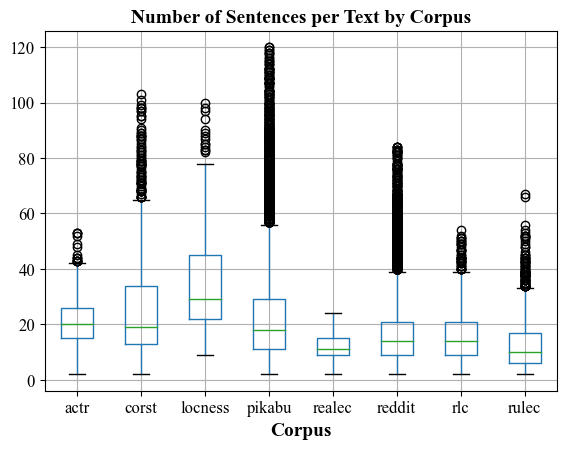

In [9]:
fig = plt.figure()
bp = data.boxplot(column='num_s', by='corpus')

# change appearance
plt.title('Number of Sentences per Text by Corpus', **tfont)
plt.suptitle('')
plt.xlabel('Corpus', **tfont)
plt.xticks(**font)
plt.yticks(**font)

# plt.savefig('num_sents.png')

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 640x480 with 0 Axes>

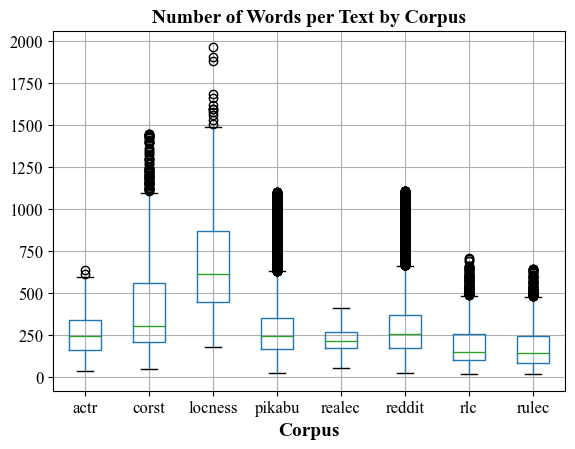

In [10]:
fig = plt.figure()
bp = data.boxplot(column='num_w', by='corpus')

# change appearance
plt.title('Number of Words per Text by Corpus', **tfont)
plt.suptitle('')
plt.xlabel('Corpus', **tfont)
plt.xticks(**font)
plt.yticks(**font)

# plt.savefig('num_words.png')

## Corpus Statistics

In [11]:
data.groupby('corpus').agg({'text': 'count',
                            'num_s': ['sum', 'mean', 'std'],
                            'num_w': ['sum', 'mean', 'std']}).round()

text     num_s                  num_w              
         count       sum  mean   std        sum   mean    std
corpus                                                       
actr       654   13693.0  21.0   9.0   167871.0  257.0  122.0
corst     1898   48625.0  26.0  19.0   796986.0  420.0  301.0
locness    393   13789.0  35.0  19.0   275690.0  702.0  345.0
pikabu   18577  428724.0  23.0  17.0  5434797.0  293.0  194.0
realec    2490   29634.0  12.0   4.0   555851.0  223.0   63.0
reddit   18720  315599.0  17.0  12.0  5681422.0  303.0  198.0
rlc       1297   21404.0  17.0  10.0   263730.0  203.0  146.0
rulec     2148   27660.0  13.0   9.0   388483.0  181.0  123.0

In [12]:
data[data['corpus'] == 'realec'].groupby('text_type').agg(
    {'text': 'count',
     'num_s': ['sum', 'mean', 'std'],
     'num_w': ['sum', 'mean', 'std']}).round()

text    num_s                num_w             
                  count      sum  mean  std       sum   mean   std
text_type                                                         
graph description  1255  11621.0   9.0  3.0  226391.0  180.0  36.0
opinion essay      1235  18013.0  15.0  4.0  329460.0  267.0  54.0

In [13]:
data[['num_s', 'num_w']].agg(['count', 'sum', 'mean', 'std']).round()

num_s       num_w
count   46177.0     46177.0
sum    899128.0  13564830.0
mean       19.0       294.0
std        15.0       202.0

In [ ]:
data['coord_to_subord'] = data.apply(lambda x: x['coord'] / x['subord'] if x['subord'] != 0 else np.nan, axis=1)
data['mcl'] = data['num_w'] / data['num_cl']
data['mtl'] = data['num_w'] / data['num_tu']

In [ ]:
# data.to_csv('SyntCompCorpus.tsv', sep='\t', index=False)

# Correlation Analysis

In [14]:
cordf = data[['corpus', 'language', 'speaker_type',
              'num_s', 'num_w', 'num_cl', 'num_tu',
              'msl', 'mcl', 'mtl', 'cps', 'cpt',
              'lev_pos', 'lev_dep',
              'mtd', 'mdtd', 'mxtd', 'mntd', 'mdd',
              'node_to_term', 'coord_to_subord', 'coord_to_comb',
              'subord_to_comb', 'coord_to_sent', 'subord_to_sent',
              'avg_np_len', 'comp_np_ratio']]

### Test for normality

In [15]:
for col in cordf.columns:
    if col in {'corpus', 'language', 'speaker_type'}:
        continue
    values = cordf[col].to_numpy()
    p_val = shapiro(values)[-1]
    if p_val < 0.05:
        print(f'Distribution of {col} is not normal, p-value={p_val}.')
    else:
        print(f'Distribution of {col} is normal, p-value-{p_val}.')

Distribution of num_s is not normal, p-value=0.0.
Distribution of num_w is not normal, p-value=0.0.
Distribution of num_cl is not normal, p-value=0.0.
Distribution of num_tu is not normal, p-value=0.0.
Distribution of msl is not normal, p-value=0.0.
Distribution of mcl is not normal, p-value=0.0.
Distribution of mtl is not normal, p-value=0.0.
Distribution of cps is not normal, p-value=0.0.
Distribution of cpt is not normal, p-value=0.0.
Distribution of lev_pos is not normal, p-value=0.0.
Distribution of lev_dep is not normal, p-value=0.0.
Distribution of mtd is not normal, p-value=0.0.
Distribution of mdtd is not normal, p-value=0.0.
Distribution of mxtd is not normal, p-value=0.0.
Distribution of mntd is not normal, p-value=0.0.
Distribution of mdd is not normal, p-value=0.0.
Distribution of node_to_term is not normal, p-value=0.0.
Distribution of coord_to_subord is normal, p-value-1.0.
Distribution of coord_to_comb is not normal, p-value=0.0.
Distribution of subord_to_comb is not no

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Overall correlation matrix

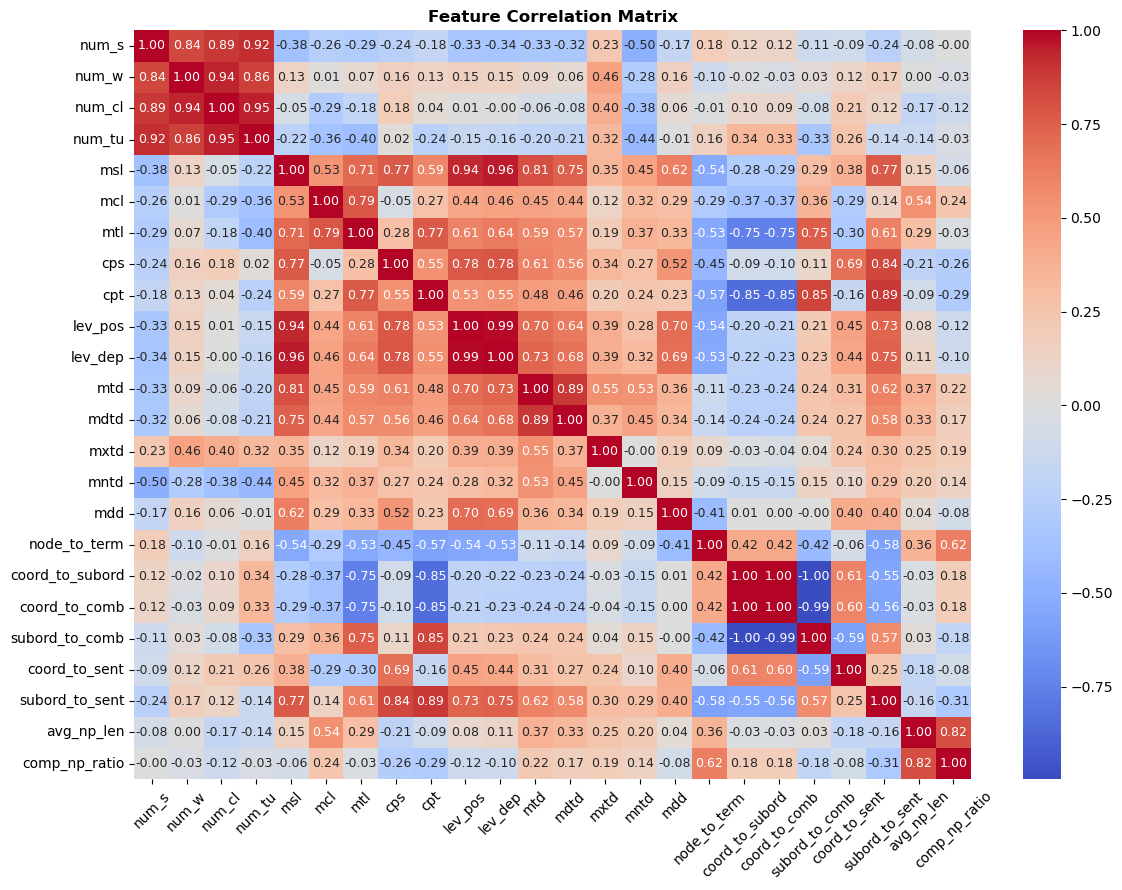

In [16]:
corr = cordf.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(corr, annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Feature Correlation Matrix', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr.png')

### Matrix for Russian

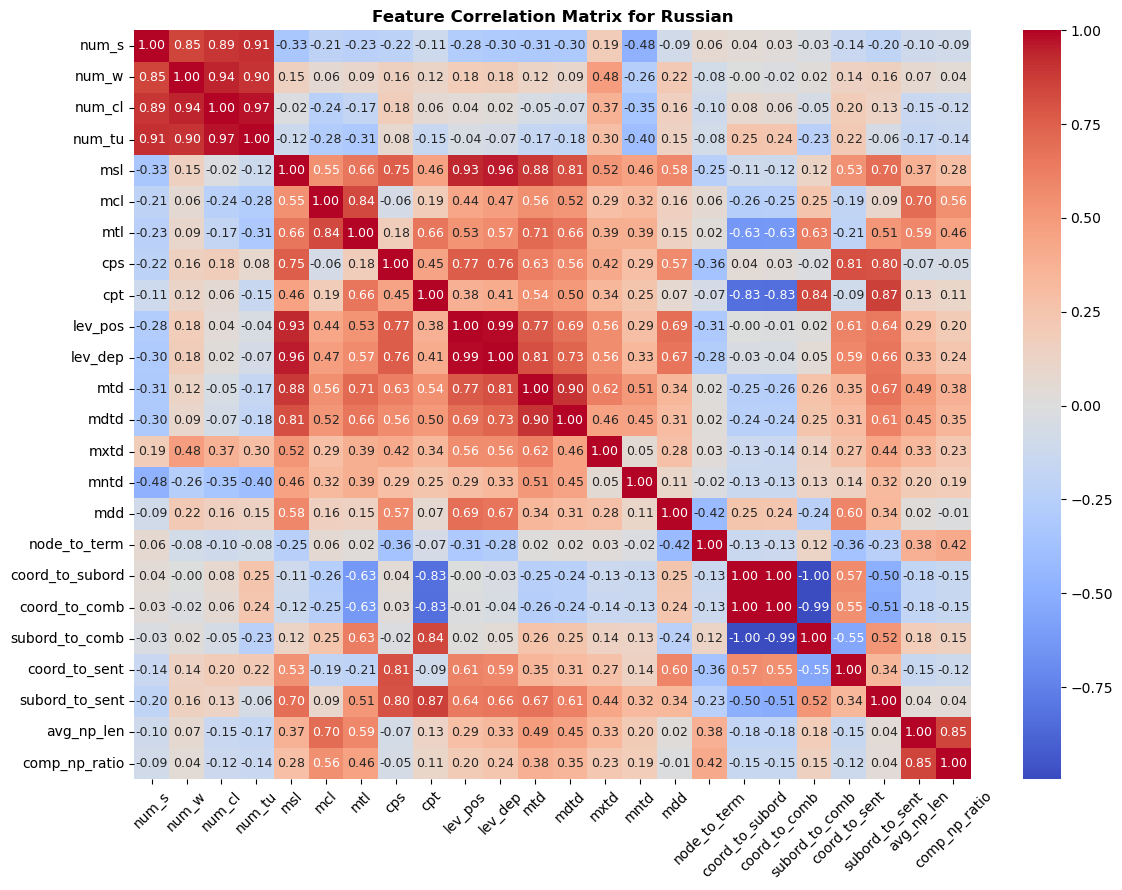

In [17]:
corr = cordf[cordf['language'] == 'russian'].corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(corr, annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Feature Correlation Matrix for Russian', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_rus.png')

### Matrix for English

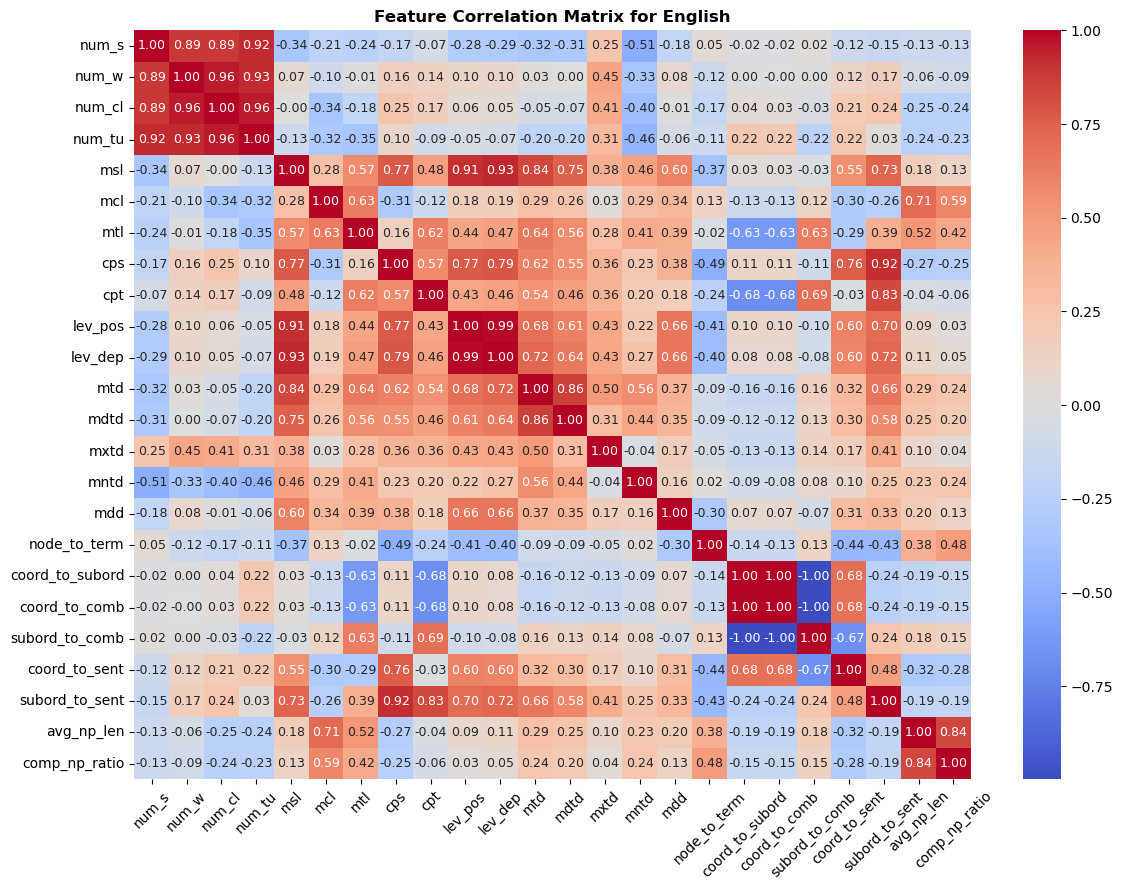

In [18]:
corr = cordf[cordf['language'] == 'english'].corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(corr, annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Feature Correlation Matrix for English', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_eng.png')

### Matrix for L1

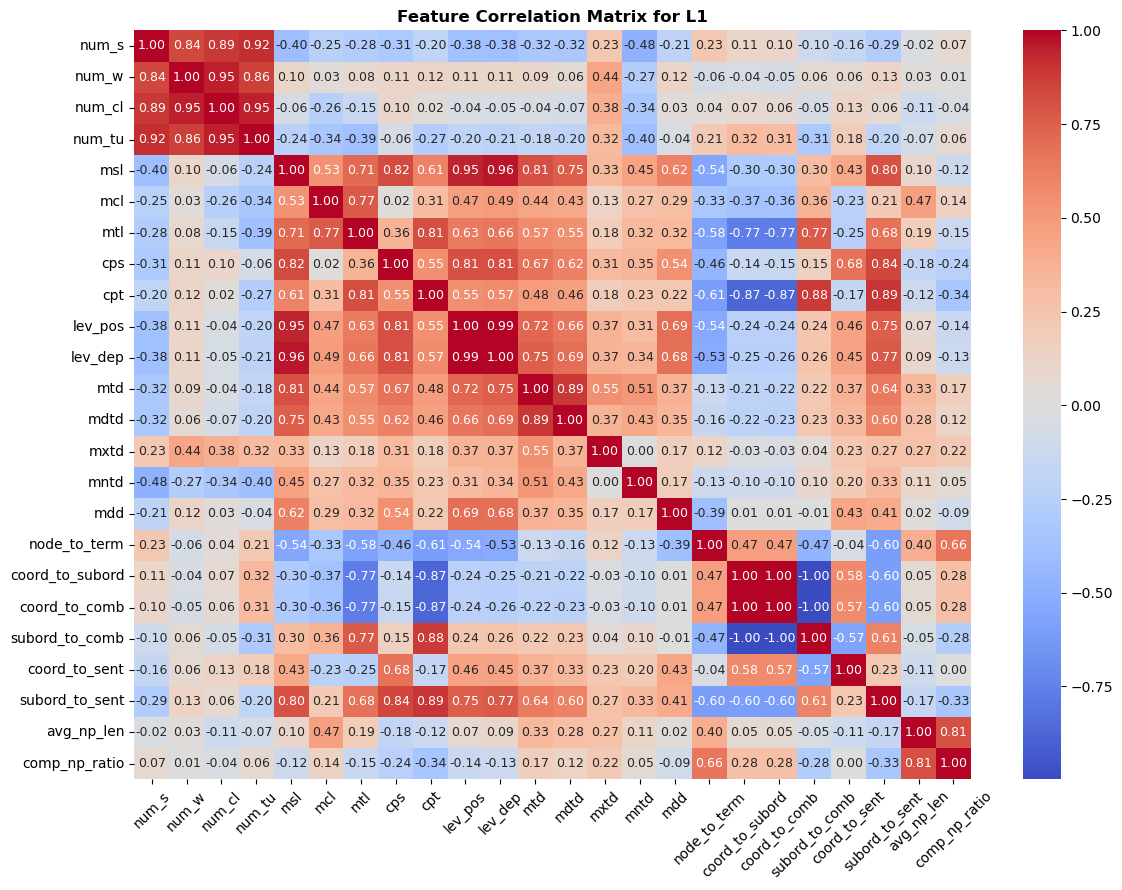

In [19]:
corr = cordf[cordf['speaker_type'] == 'L1'].corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(corr, annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Feature Correlation Matrix for L1', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l1.png')

### Matrix for L2

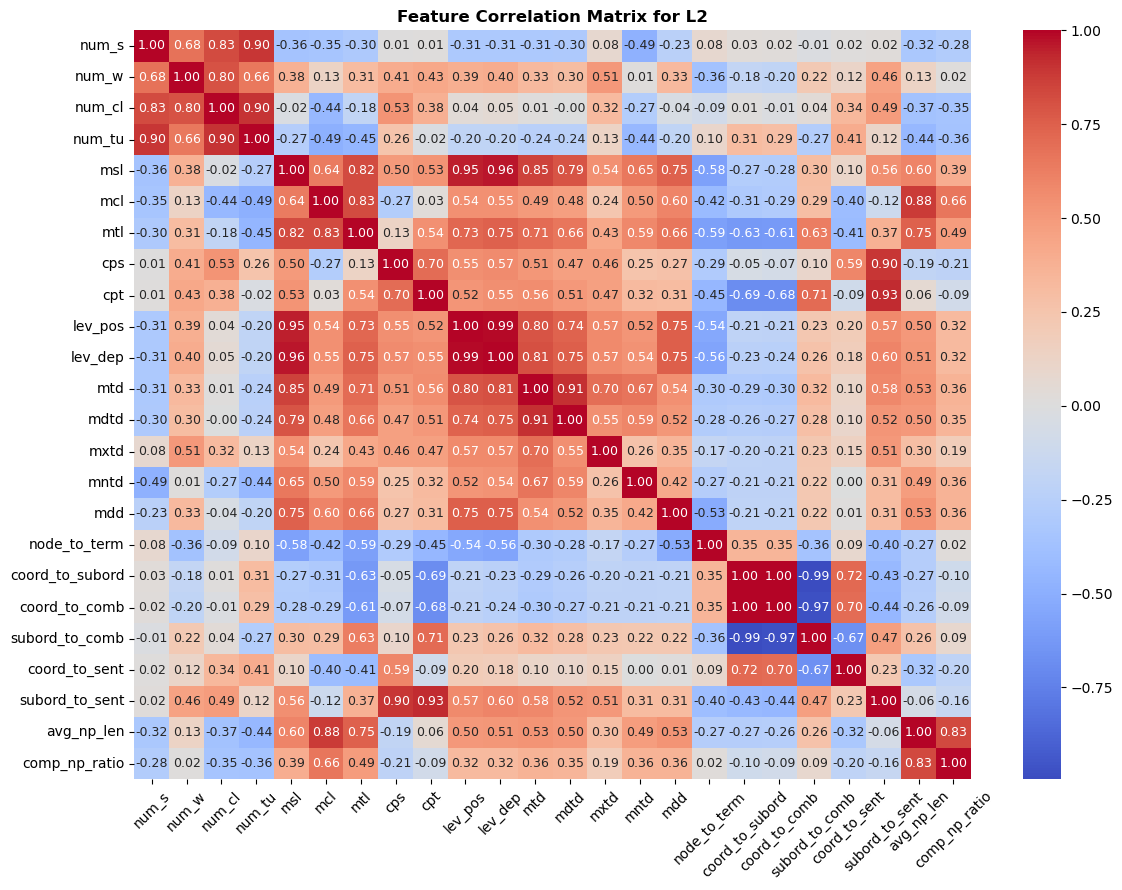

In [20]:
corr = cordf[cordf['speaker_type'] == 'L2'].corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(corr, annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Feature Correlation Matrix for L2', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l2.png')

In [21]:
for_graphs = []
for language in ['russian', 'english']:
    for speaker_type in ['L1', 'L2']:
        for_graphs.append(cordf[(cordf['language'] == language) & (cordf['speaker_type'] == speaker_type)].corr(
            method='spearman', numeric_only=True))

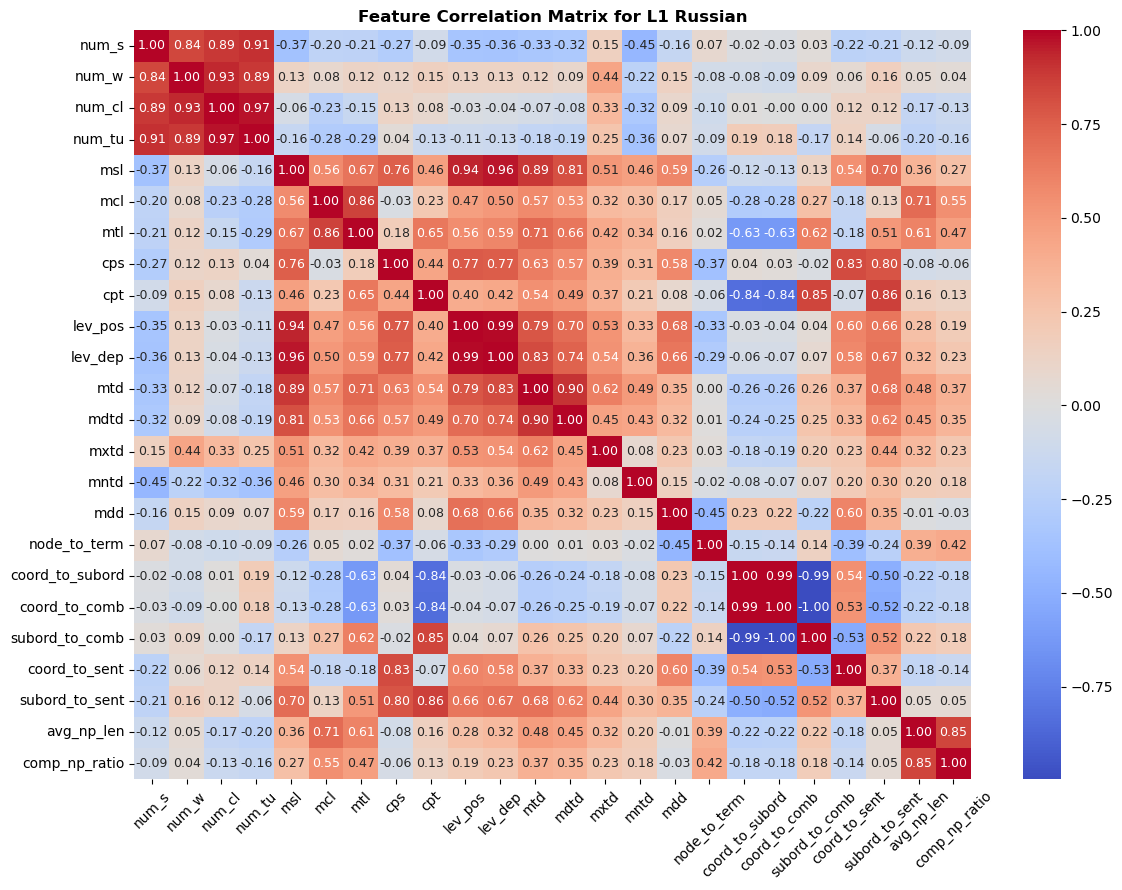

In [22]:
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(for_graphs[0], annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=for_graphs[0].columns, yticklabels=for_graphs[0].columns)

plt.title('Feature Correlation Matrix for L1 Russian', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l1_rus.png')

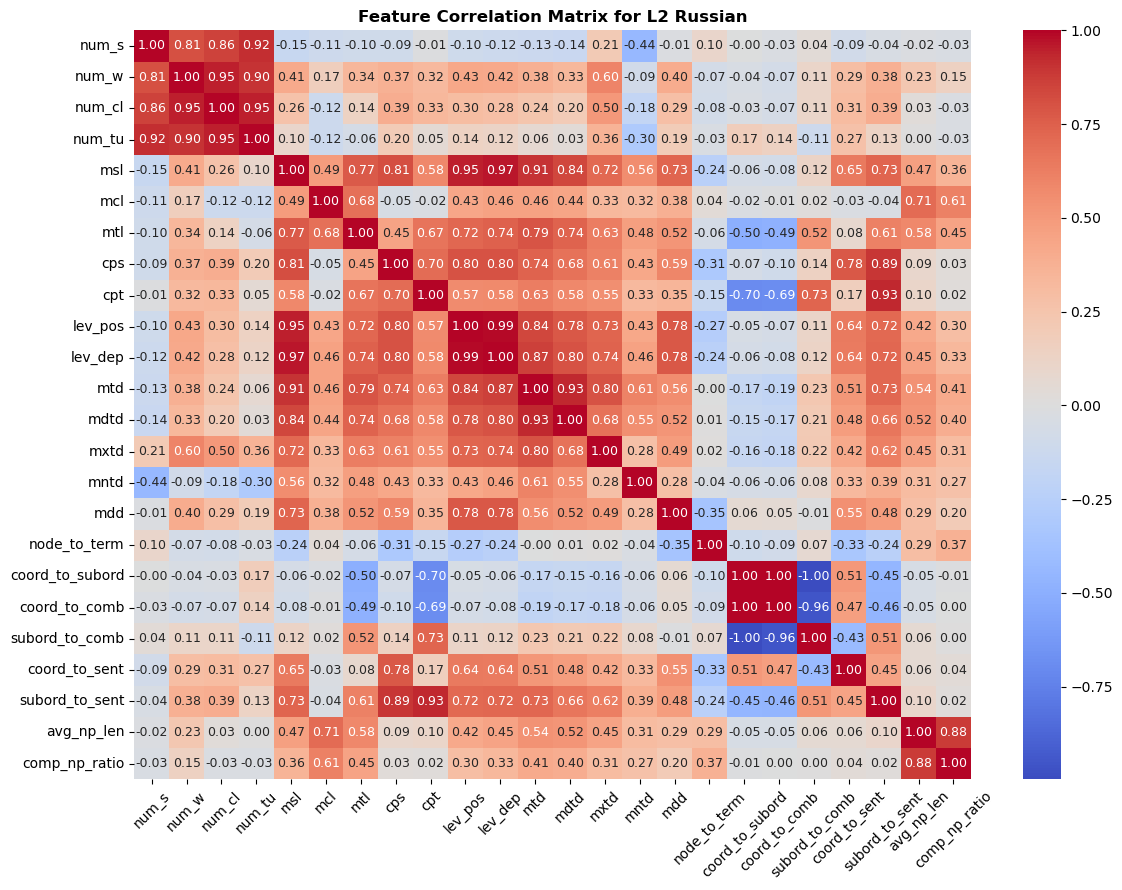

In [23]:
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(for_graphs[1], annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=for_graphs[1].columns, yticklabels=for_graphs[1].columns)

plt.title('Feature Correlation Matrix for L2 Russian', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l2_rus.png')

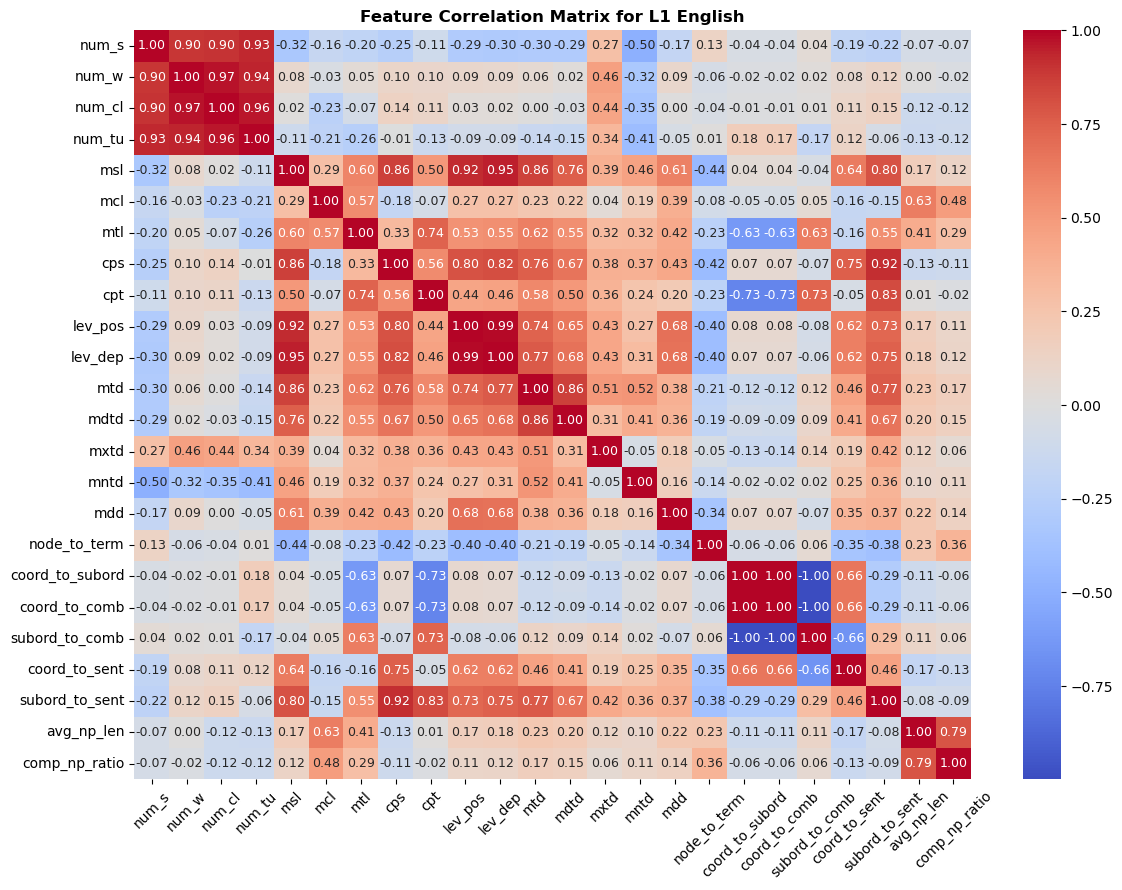

In [24]:
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(for_graphs[2], annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=for_graphs[2].columns, yticklabels=for_graphs[2].columns)

plt.title('Feature Correlation Matrix for L1 English', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l1_eng.png')

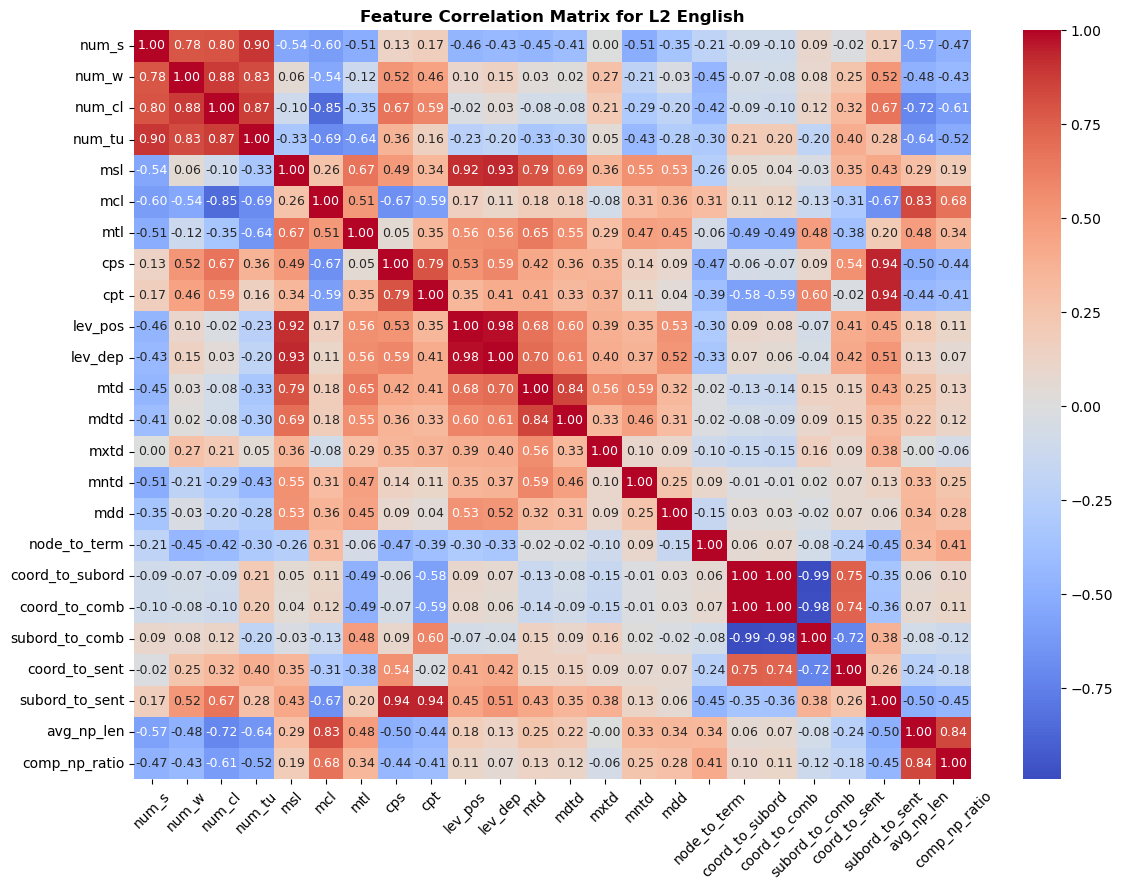

In [25]:
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(for_graphs[3], annot=True, annot_kws={'fontsize': 9}, fmt='.2f', cmap='coolwarm', cbar=True,
                      xticklabels=for_graphs[3].columns, yticklabels=for_graphs[3].columns)

plt.title('Feature Correlation Matrix for L2 English', **{'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('feature_corr_l2_eng.png')

## Descriptive statistics & ANOVA

In [15]:
stat_col = ['msl', 'mcl', 'mtl', 'cps', 'cpt',
            'lev_pos', 'lev_dep',
            'mtd', 'mdtd', 'mxtd', 'mntd', 'mdd',
            'node_to_term', 'coord_to_subord', 'coord_to_comb',
            'subord_to_comb', 'coord_to_sent', 'subord_to_sent',
            'avg_np_len', 'comp_np_ratio']

#### Task type (REALEC)

In [130]:
realec = data[data['corpus'] == 'realec']
realecg = realec.groupby('text_type')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = realecg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        one = realec[realec['text_type'] == 'graph description'][rec['level_0']]
        two = realec[realec['text_type'] == 'opinion essay'][rec['level_0']]
        rec['F-statistic'], rec['p-value'] = f_oneway(one, two, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

realecg = pd.DataFrame(recs)
realecg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
realecg.to_excel('anova_realec.xlsx', index=False)
realecg

Complexity Measure level_1  graph description  opinion essay  F-statistic  \
0                 msl    mean              20.40          18.84    76.929457   
1                 msl     std               4.88           3.94          NaN   
2                 mcl    mean              10.20           6.84  2680.097383   
3                 mcl     std               2.05           1.02          NaN   
4                 mtl    mean              16.40          13.97   316.642926   
5                 mtl     std               3.99           2.68          NaN   
6                 cps    mean               2.05           2.79   977.365014   
7                 cps     std               0.56           0.62          NaN   
8                 cpt    mean               1.64           2.06   777.674927   
9                 cpt     std               0.39           0.36          NaN   
10            lev_pos    mean              16.80          15.93    31.541556   
11            lev_pos     std               4.16           3.58          NaN   
12            lev_dep    mean              18.52          18.14     4.773865   
13            lev_dep     std               4.52           4.00          NaN   
14                mtd    mean               5.59           5.39    56.029631   
15                mtd     std               0.70           0.60          NaN   
16               mdtd    mean               5.49           5.26    54.348839   
17               mdtd     std               0.82           0.71          NaN   
18               mxtd    mean               7.82           8.18    51.550804   
19               mxtd     std               1.19           1.33          NaN   
20               mntd    mean               3.74           3.22   247.799715   
21               mntd     std               0.89           0.77          NaN   
22                mdd    mean               2.98           2.85   153.794415   
23                mdd     std               0.28           0.23          NaN   
24       node_to_term    mean               0.81           0.73   673.195225   
25       node_to_term     std               0.09           0.06          NaN   
26    coord_to_subord    mean               0.53           0.27   126.765003   
27    coord_to_subord     std               0.80           0.19          NaN   
28      coord_to_comb    mean               0.27           0.20   105.582352   
29      coord_to_comb     std               0.23           0.10          NaN   
30     subord_to_comb    mean               0.72           0.80   117.524126   
31     subord_to_comb     std               0.24           0.10          NaN   
32      coord_to_sent    mean               0.28           0.36    73.542991   
33      coord_to_sent     std               0.25           0.22          NaN   
34     subord_to_sent    mean               0.77           1.43  1095.365939   
35     subord_to_sent     std               0.48           0.51          NaN   
36         avg_np_len    mean               2.92           2.14  2194.817835   
37         avg_np_len     std               0.52           0.28          NaN   
38      comp_np_ratio    mean               0.66           0.53  1617.702580   
39      comp_np_ratio     std               0.09           0.08          NaN   

          p-value Significance Level  
0    3.221313e-18                ***  
1             NaN                NaN  
2    0.000000e+00                ***  
3             NaN                NaN  
4    9.003836e-67                ***  
5             NaN                NaN  
6   2.941055e-181                ***  
7             NaN                NaN  
8   3.719787e-149                ***  
9             NaN                NaN  
10   2.169057e-08                ***  
11            NaN                NaN  
12   2.898789e-02                  *  
13            NaN                NaN  
14   9.848963e-14                ***  
15            NaN                NaN  
16   2.273523e-13                ***  
17            NaN   

#### Proficiency level: Russian

In [16]:
actr_conv = {'A3': 'B1_',
             'A4': 'B1_',
             'B1': 'B2_',
             'B3': 'C1_'}
level_conv = {'NM': 'A0',
              'NH': 'A1',
              'IL': 'A2',
              'IM': 'B1',
              'IH': 'B1',
              'AL': 'B2',
              'AM': 'B2',
              'AH': 'C1'}

In [17]:
levels = data[(data['level'].notnull()) & (data['language'] == 'russian') & (data['corpus'] != 'actr')]
levels = levels[~levels['level'].isin({'Other', 'Heritage 1', 'Heritage 2', 'Heritage 3', 'NL'})]
levels['level'] = levels.apply(lambda x: actr_conv[x['level']] if x['level'] in actr_conv and x['corpus'] == 'actr' else x['level'], axis=1)
levels['level'] = levels['level'].map(lambda x: level_conv[x] if x in level_conv else x)
levels['level'] = levels['level'].map(lambda x: x.strip('_') if isinstance(x, str) else x)

In [18]:
levelg = levels.groupby('level')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = levelg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in {'A0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'}:
            samples.append(levels[levels['level'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

levelg = pd.DataFrame(recs)
levelg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
levelg.to_excel('anova_proficiency.xlsx', index=False)
levelg

Complexity Measure level_1     A0     A1     A2     B1     B2     C1  \
0                 msl    mean   9.66   9.14  10.50  14.01  14.97  14.06   
1                 msl     std   4.83   6.49   4.68   6.52   4.50   4.18   
2                 mcl    mean   4.65   4.74   4.87   5.31   5.77   5.67   
3                 mcl     std   1.01   1.20   1.16   1.20   1.28   1.31   
4                 mtl    mean   6.30   6.06   6.80   8.63   9.29   9.32   
5                 mtl     std   2.53   1.96   1.85   2.41   2.38   2.39   
6                 cps    mean   2.04   1.94   2.20   2.67   2.66   2.47   
7                 cps     std   0.76   1.37   0.95   1.12   0.83   0.51   
8                 cpt    mean   1.33   1.30   1.41   1.64   1.63   1.65   
9                 cpt     std   0.26   0.40   0.31   0.34   0.32   0.23   
10            lev_pos    mean  10.28   8.59   9.65  12.69  13.30  12.71   
11            lev_pos     std   9.44  10.94   5.44   6.77   4.77   3.65   
12            lev_dep    mean  10.50   9.08  10.35  13.90  14.78  14.02   
13            lev_dep     std   9.25  11.13   5.78   7.20   5.07   4.16   
14                mtd    mean   3.79   3.74   4.08   5.01   5.35   5.12   
15                mtd     std   0.79   0.86   0.80   1.01   0.88   1.05   
16               mdtd    mean   3.75   3.57   3.92   4.87   5.21   4.93   
17               mdtd     std   0.79   0.90   0.85   1.07   0.98   1.06   
18               mxtd    mean   5.78   5.44   6.28   7.79   8.18   7.73   
19               mxtd     std   1.93   1.71   1.64   2.00   1.70   2.11   
20               mntd    mean   2.33   2.52   2.49   2.95   3.18   3.08   
21               mntd     std   0.69   0.72   0.70   0.98   1.03   1.10   
22                mdd    mean   2.36   2.32   2.42   2.59   2.65   2.70   
23                mdd     std   0.53   0.67   0.45   0.47   0.38   0.35   
24       node_to_term    mean   0.97   1.02   0.95   0.97   0.99   0.98   
25       node_to_term     std   0.11   0.16   0.13   0.13   0.14   0.14   
26    coord_to_subord    mean   1.14   1.36   1.16   0.78   0.82   0.59   
27    coord_to_subord     std   0.62   1.51   1.59   0.79   0.95   0.45   
28      coord_to_comb    mean   0.44   0.52   0.45   0.38   0.39   0.33   
29      coord_to_comb     std   0.21   0.33   0.24   0.17   0.17   0.15   
30     subord_to_comb    mean   0.45   0.42   0.54   0.61   0.61   0.67   
31     subord_to_comb     std   0.21   0.32   0.25   0.17   0.17   0.15   
32      coord_to_sent    mean   0.51   0.49   0.55   0.62   0.65   0.51   
33      coord_to_sent     std   0.43   0.95   0.53   0.48   0.46   0.31   
34     subord_to_sent    mean   0.53   0.45   0.65   1.04   1.01   0.96   
35     subord_to_sent     std   0.43   0.60   0.61   0.76   0.55   0.33   
36         avg_np_len    mean   1.68   1.66   1.65   1.92   2.10   1.99   
37         avg_np_len     std   0.22   0.23   0.23   0.31   0.36   0.36   
38      comp_np_ratio    mean   0.46   0.48   0.44   0.53   0.58   0.56   
39      comp_np_ratio     std   0.08   0.12   0.12   0.11   0.11   0.13   

       C2  Native  F-statistic        p-value Significance Level  
0   12.95   14.88    41.061068   1.486815e-48                ***  
1    2.35    9.25          NaN            NaN                NaN  
2    4.83    5.17    37.717581   1.506452e-44                ***  
3    0.81    2.29          NaN            NaN                NaN  
4    7.19    7.51    72.240319   4.626816e-85                ***  
5    1.54    3.12          NaN            NaN                NaN  
6    2.75    2.91    18.111461   8.499288e-21                ***  
7    0.64    1.72          NaN            NaN                NaN  
8    1.49    1.45    35.776312   3.243640e-42                ***  
9    0.17    0.24          NaN            NaN                NaN  
10  11.85   15.17    22.180934   9.457856e-26                ***  
11   2.38   12.25          NaN            NaN                NaN  
12  12.85   16.33    29.301203   2.131440e-34           

In [19]:
levels['level'].value_counts()

level
Native    20475
B2         1528
B1         1449
A2          252
A1          111
C1           49
A0           18
C2           13
Name: count, dtype: int64

In [20]:
levels.shape

(23895, 40)

#### Formal vs. informal in native English and Russian

In [136]:
genre = data[data['corpus'].isin({'corst', 'locness', 'reddit', 'pikabu'})]
genre.loc[genre['corpus'].isin({'corst', 'locness'}), 'genre'] = 'formal'
genre.loc[~genre['corpus'].isin({'corst', 'locness'}), 'genre'] = 'informal'
genre['genre'] = genre['language'] + ' ' + genre['genre']
genre.shape

(39588, 41)

In [137]:
genre['genre'].value_counts()

genre
english informal    18720
russian informal    18577
russian formal       1898
english formal        347
Name: count, dtype: int64

In [140]:
genreg = genre[genre['genre'].isin({'russian formal', 'russian informal'})].groupby('genre')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = genreg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in ['russian formal', 'russian informal']:
            samples.append(genre[genre['genre'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

genreg = pd.DataFrame(recs)
genreg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
genreg.to_excel('anova_russian_genre.xlsx', index=False)
genreg

Complexity Measure level_1  russian formal  russian informal  F-statistic  \
0                 msl    mean           17.44             14.62   161.597920   
1                 msl     std            6.86              9.42          NaN   
2                 mcl    mean            6.02              5.09   293.080349   
3                 mcl     std            4.48              1.91          NaN   
4                 mtl    mean            9.67              7.28  1061.863665   
5                 mtl     std            4.75              2.81          NaN   
6                 cps    mean            2.99              2.90     4.076788   
7                 cps     std            0.99              1.77          NaN   
8                 cpt    mean            1.63              1.43  1277.609321   
9                 cpt     std            0.27              0.23          NaN   
10            lev_pos    mean           16.23             15.06    15.888546   
11            lev_pos     std            6.83             12.67          NaN   
12            lev_dep    mean           18.11             16.14    41.833626   
13            lev_dep     std            7.72             13.02          NaN   
14                mtd    mean            5.88              4.86  2047.578019   
15                mtd     std            0.95              0.93          NaN   
16               mdtd    mean            5.72              4.66  1832.028798   
17               mdtd     std            1.07              1.03          NaN   
18               mxtd    mean           10.15              8.55  1075.507657   
19               mxtd     std            2.05              2.02          NaN   
20               mntd    mean            2.82              2.45   338.551293   
21               mntd     std            1.09              0.82          NaN   
22                mdd    mean            2.95              3.01     0.647481   
23                mdd     std            5.57              2.92          NaN   
24       node_to_term    mean            1.07              0.97  1234.999548   
25       node_to_term     std            0.12              0.13          NaN   
26    coord_to_subord    mean            0.94              1.49   188.810438   
27    coord_to_subord     std            1.36              1.69          NaN   
28      coord_to_comb    mean            0.42              0.54   923.469783   
29      coord_to_comb     std            0.15              0.16          NaN   
30     subord_to_comb    mean            0.58              0.46   914.951046   
31     subord_to_comb     std            0.15              0.16          NaN   
32      coord_to_sent    mean            0.85              1.05    49.742033   
33      coord_to_sent     std            0.57              1.25          NaN   
34     subord_to_sent    mean            1.14              0.85   316.537192   
35     subord_to_sent     std            0.59              0.68          NaN   
36         avg_np_len    mean            2.27              1.96  1347.190039   
37         avg_np_len     std            0.35              0.35          NaN   
38      comp_np_ratio    mean            0.61              0.53   980.830289   
39      comp_np_ratio     std            0.09              0.10          NaN   

          p-value Significance Level  
0    6.982310e-37                ***  
1             NaN                NaN  
2    3.017849e-65                ***  
3             NaN                NaN  
4   3.975386e-227                ***  
5             NaN                NaN  
6    4.348925e-02                  *  
7             NaN                NaN  
8   1.756131e-271                ***  
9             NaN                NaN  
10   6.741702e-05                ***  
11            NaN                NaN  
12   1.016258e-10                ***  
13            NaN                NaN  
14   0.000000e+00                ***  
15            NaN                NaN  
16   0.000000e+00                ***  
17            NaN   

In [163]:
genreg = genre[genre['genre'].isin({'english formal', 'english informal'})].groupby('genre')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = genreg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in ['english formal', 'english informal']:
            samples.append(genre[genre['genre'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

genreg = pd.DataFrame(recs)
genreg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
genreg.to_excel('anova_english_genre.xlsx', index=False)
genreg

Complexity Measure level_1  english formal  english informal  F-statistic  \
0                 msl    mean           21.16             19.46    19.546170   
1                 msl     std            4.60              7.12          NaN   
2                 mcl    mean            7.06              5.84   101.514028   
3                 mcl     std            1.07              2.25          NaN   
4                 mtl    mean           14.79             11.13   423.809000   
5                 mtl     std            2.84              3.29          NaN   
6                 cps    mean            3.02              3.37    30.197698   
7                 cps     std            0.61              1.18          NaN   
8                 cpt    mean            2.10              1.91    89.029534   
9                 cpt     std            0.30              0.37          NaN   
10            lev_pos    mean           18.84             19.03     0.169449   
11            lev_pos     std            4.49              8.50          NaN   
12            lev_dep    mean           21.04             20.69     0.511795   
13            lev_dep     std            4.87              8.96          NaN   
14                mtd    mean            5.49              5.05   115.650616   
15                mtd     std            0.57              0.76          NaN   
16               mdtd    mean            5.35              4.97    68.465916   
17               mdtd     std            0.63              0.86          NaN   
18               mxtd    mean            9.06              8.06   142.181943   
19               mxtd     std            1.48              1.56          NaN   
20               mntd    mean            2.83              2.66    10.786448   
21               mntd     std            0.79              0.96          NaN   
22                mdd    mean            3.02              2.96     1.242324   
23                mdd     std            0.25              0.93          NaN   
24       node_to_term    mean            0.68              0.64    97.065309   
25       node_to_term     std            0.05              0.07          NaN   
26    coord_to_subord    mean            0.29              0.52   122.089667   
27    coord_to_subord     std            0.14              0.40          NaN   
28      coord_to_comb    mean            0.22              0.32   272.784511   
29      coord_to_comb     std            0.08              0.12          NaN   
30     subord_to_comb    mean            0.78              0.68   272.142698   
31     subord_to_comb     std            0.08              0.12          NaN   
32      coord_to_sent    mean            0.44              0.77   117.036962   
33      coord_to_sent     std            0.23              0.57          NaN   
34     subord_to_sent    mean            1.58              1.60     0.195331   
35     subord_to_sent     std            0.47              0.77          NaN   
36         avg_np_len    mean            2.28              1.79  1640.639038   
37         avg_np_len     std            0.31              0.22          NaN   
38      comp_np_ratio    mean            0.54              0.41  1109.834698   
39      comp_np_ratio     std            0.07              0.07          NaN   

          p-value Significance Level  
0    9.873992e-06                ***  
1             NaN                NaN  
2    8.140206e-24                ***  
3             NaN                NaN  
4    3.725002e-93                ***  
5             NaN                NaN  
6    3.951694e-08                ***  
7             NaN                NaN  
8    4.324272e-21                ***  
9             NaN                NaN  
10   6.806068e-01                NaN  
11            NaN                NaN  
12   4.743714e-01                NaN  
13            NaN                NaN  
14   6.770920e-27                ***  
15            NaN                NaN  
16   1.374980e-16                ***  
17            NaN   

In [142]:
genreg = genre[genre['genre'].isin({'russian formal', 'english formal'})].groupby('genre')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = genreg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in ['russian formal', 'english formal']:
            samples.append(genre[genre['genre'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

genreg = pd.DataFrame(recs)
genreg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
genreg.to_excel('anova_formal_language.xlsx', index=False)
genreg

Complexity Measure level_1  english formal  russian formal  F-statistic  \
0                 msl    mean           21.16           17.44    94.338998   
1                 msl     std            4.60            6.86          NaN   
2                 mcl    mean            7.06            6.02    18.411703   
3                 mcl     std            1.07            4.48          NaN   
4                 mtl    mean           14.79            9.67   377.719740   
5                 mtl     std            2.84            4.75          NaN   
6                 cps    mean            3.02            2.99     0.349631   
7                 cps     std            0.61            0.99          NaN   
8                 cpt    mean            2.10            1.63   865.693455   
9                 cpt     std            0.30            0.27          NaN   
10            lev_pos    mean           18.84           16.23    46.924765   
11            lev_pos     std            4.49            6.83          NaN   
12            lev_dep    mean           21.04           18.11    46.428306   
13            lev_dep     std            4.87            7.72          NaN   
14                mtd    mean            5.49            5.88    52.823957   
15                mtd     std            0.57            0.95          NaN   
16               mdtd    mean            5.35            5.72    39.633042   
17               mdtd     std            0.63            1.07          NaN   
18               mxtd    mean            9.06           10.15    89.805436   
19               mxtd     std            1.48            2.05          NaN   
20               mntd    mean            2.83            2.82     0.023463   
21               mntd     std            0.79            1.09          NaN   
22                mdd    mean            3.02            2.95     0.048909   
23                mdd     std            0.25            5.57          NaN   
24       node_to_term    mean            0.68            1.07  3399.163523   
25       node_to_term     std            0.05            0.12          NaN   
26    coord_to_subord    mean            0.29            0.94    79.604675   
27    coord_to_subord     std            0.14            1.36          NaN   
28      coord_to_comb    mean            0.22            0.42   632.319894   
29      coord_to_comb     std            0.08            0.15          NaN   
30     subord_to_comb    mean            0.78            0.58   634.409848   
31     subord_to_comb     std            0.08            0.15          NaN   
32      coord_to_sent    mean            0.44            0.85   171.112503   
33      coord_to_sent     std            0.23            0.57          NaN   
34     subord_to_sent    mean            1.58            1.14   169.708433   
35     subord_to_sent     std            0.47            0.59          NaN   
36         avg_np_len    mean            2.28            2.27     0.364660   
37         avg_np_len     std            0.31            0.35          NaN   
38      comp_np_ratio    mean            0.54            0.61   176.832803   
39      comp_np_ratio     std            0.07            0.09          NaN   

          p-value Significance Level  
0    7.122731e-22                ***  
1             NaN                NaN  
2    1.855188e-05                ***  
3             NaN                NaN  
4    6.955223e-78                ***  
5             NaN                NaN  
6    5.543814e-01                NaN  
7             NaN                NaN  
8   3.408010e-161                ***  
9             NaN                NaN  
10   9.493477e-12                ***  
11            NaN                NaN  
12   1.216761e-11                ***  
13            NaN                NaN  
14   5.012815e-13                ***  
15            NaN                NaN  
16   3.675184e-10                ***  
17            NaN                NaN  
18   6.431797e-21                ***  
19            NaN       

In [143]:
genreg = genre[genre['genre'].isin({'russian informal', 'english informal'})].groupby('genre')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = genreg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in ['russian informal', 'english informal']:
            samples.append(genre[genre['genre'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

genreg = pd.DataFrame(recs)
genreg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
genreg.to_excel('anova_informal_language.xlsx', index=False)
genreg

Complexity Measure level_1  english informal  russian informal  \
0                 msl    mean             19.46             14.62   
1                 msl     std              7.12              9.42   
2                 mcl    mean              5.84              5.09   
3                 mcl     std              2.25              1.91   
4                 mtl    mean             11.13              7.28   
5                 mtl     std              3.29              2.81   
6                 cps    mean              3.37              2.90   
7                 cps     std              1.18              1.77   
8                 cpt    mean              1.91              1.43   
9                 cpt     std              0.37              0.23   
10            lev_pos    mean             19.03             15.06   
11            lev_pos     std              8.50             12.67   
12            lev_dep    mean             20.69             16.14   
13            lev_dep     std              8.96             13.02   
14                mtd    mean              5.05              4.86   
15                mtd     std              0.76              0.93   
16               mdtd    mean              4.97              4.66   
17               mdtd     std              0.86              1.03   
18               mxtd    mean              8.06              8.55   
19               mxtd     std              1.56              2.02   
20               mntd    mean              2.66              2.45   
21               mntd     std              0.96              0.82   
22                mdd    mean              2.96              3.01   
23                mdd     std              0.93              2.92   
24       node_to_term    mean              0.64              0.97   
25       node_to_term     std              0.07              0.13   
26    coord_to_subord    mean              0.52              1.49   
27    coord_to_subord     std              0.40              1.69   
28      coord_to_comb    mean              0.32              0.54   
29      coord_to_comb     std              0.12              0.16   
30     subord_to_comb    mean              0.68              0.46   
31     subord_to_comb     std              0.12              0.16   
32      coord_to_sent    mean              0.77              1.05   
33      coord_to_sent     std              0.57              1.25   
34     subord_to_sent    mean              1.60              0.85   
35     subord_to_sent     std              0.77              0.68   
36         avg_np_len    mean              1.79              1.96   
37         avg_np_len     std              0.22              0.35   
38      comp_np_ratio    mean              0.41              0.53   
39      comp_np_ratio     std              0.07              0.10   

     F-statistic        p-value Significance Level  
0    3145.653639   0.000000e+00                ***  
1            NaN            NaN                NaN  
2    1234.072257  5.317944e-266                ***  
3            NaN            NaN                NaN  
4   14693.100490   0.000000e+00                ***  
5            NaN            NaN                NaN  
6     887.691641  8.528957e-193                ***  
7            NaN            NaN                NaN  
8   23278.031496   0.000000e+00                ***  
9            NaN            NaN                NaN  
10   1266.331723  8.759581e-273                ***  
11           NaN            NaN                NaN  
12   1546.725962   0.000000e+00                ***  
13           NaN            NaN                NaN  
14    493.892583  1.031846e-108                ***  
15           NaN            NaN                NaN  
16    974.434453  3.419791e-211                ***  
17           NaN            NaN                NaN  
18    703.504245  1.382566e-153                ***  
19           NaN            NaN                NaN  
20    533.778386  2.842229e-117                ***  
21     

#### HL vs. FL Russian

In [159]:
heritage = data[(data['language_background'] == 'HL') | (data['level'].str.contains('Heritage'))]
heritage.shape

(567, 40)

In [158]:
foreign = data[(data['language'] == 'russian') & (data['speaker_type'] == 'L2')]
foreign = foreign[~foreign['level'].str.contains('Heritage', na=False)]
foreign = foreign[foreign['language_background'] != 'HL']
foreign.shape

(1768, 40)

In [161]:
heritage['HL/FL'] = 'HL'
foreign['HL/FL'] = 'FL'
background = pd.concat([heritage, foreign])
print(background.shape)
background['HL/FL'].value_counts()

(2335, 41)


HL/FL
FL    1768
HL     567
Name: count, dtype: int64

In [162]:
backgroundg = background.groupby('HL/FL')[stat_col].agg(['mean', 'std']).transpose().round(2).reset_index()
recs = backgroundg.to_dict(orient='records')
for i, rec in enumerate(recs):
    if rec['level_1'] == 'mean':
        samples = []
        for lvl in ['FL', 'HL']:
            samples.append(background[background['HL/FL'] == lvl][rec['level_0']])
        rec['F-statistic'], rec['p-value'] = f_oneway(*samples, nan_policy='omit')
        if rec['p-value'] < 0.001:
            rec['Significance Level'] = '***'
        elif rec['p-value'] < 0.01:
            rec['Significance Level'] = '**'
        elif rec['p-value'] < 0.05:
            rec['Significance Level'] = '*'
        elif rec['p-value'] == 0.05:
            rec['Significance Level'] = '.'

backgroundg = pd.DataFrame(recs)
backgroundg.rename(columns={'level_0': 'Complexity Measure'}, inplace=True)
backgroundg.to_excel('anova_heritage.xlsx', index=False)
backgroundg

Complexity Measure level_1     FL     HL  F-statistic       p-value  \
0                 msl    mean  12.68  13.68    11.379381  7.547694e-04   
1                 msl     std   6.60   4.43          NaN           NaN   
2                 mcl    mean   4.97   5.48    79.809945  8.170011e-19   
3                 mcl     std   1.21   1.08          NaN           NaN   
4                 mtl    mean   7.73   8.59    60.326517  1.194073e-14   
5                 mtl     std   2.39   2.02          NaN           NaN   
6                 cps    mean   2.56   2.54     0.180442  6.710331e-01   
7                 cps     std   1.15   0.84          NaN           NaN   
8                 cpt    mean   1.56   1.58     1.136560  2.864908e-01   
9                 cpt     std   0.35   0.27          NaN           NaN   
10            lev_pos    mean  11.74  12.32     3.177741  7.477788e-02   
11            lev_pos     std   7.32   4.77          NaN           NaN   
12            lev_dep    mean  12.66  13.55     6.495216  1.088007e-02   
13            lev_dep     std   7.79   5.12          NaN           NaN   
14                mtd    mean   4.61   4.94    45.641409  1.787221e-11   
15                mtd     std   1.07   0.87          NaN           NaN   
16               mdtd    mean   4.46   4.84    54.340060  2.329237e-13   
17               mdtd     std   1.10   0.97          NaN           NaN   
18               mxtd    mean   7.35   7.54     3.817517  5.083869e-02   
19               mxtd     std   2.16   1.62          NaN           NaN   
20               mntd    mean   2.66   2.94    46.648728  1.079498e-11   
21               mntd     std   0.85   0.90          NaN           NaN   
22                mdd    mean   2.56   2.59     1.440856  2.301228e-01   
23                mdd     std   0.50   0.34          NaN           NaN   
24       node_to_term    mean   0.94   0.97    18.118127  2.158271e-05   
25       node_to_term     std   0.13   0.15          NaN           NaN   
26    coord_to_subord    mean   0.91   0.83     2.881260  8.975310e-02   
27    coord_to_subord     std   1.01   1.05          NaN           NaN   
28      coord_to_comb    mean   0.42   0.39     7.346040  6.770271e-03   
29      coord_to_comb     std   0.20   0.18          NaN           NaN   
30     subord_to_comb    mean   0.58   0.61     9.457747  2.126967e-03   
31     subord_to_comb     std   0.20   0.19          NaN           NaN   
32      coord_to_sent    mean   0.63   0.62     0.128378  7.201519e-01   
33      coord_to_sent     std   0.55   0.50          NaN           NaN   
34     subord_to_sent    mean   0.93   0.92     0.146232  7.021972e-01   
35     subord_to_sent     std   0.76   0.48          NaN           NaN   
36         avg_np_len    mean   1.76   1.95   161.039527  9.887205e-36   
37         avg_np_len     std   0.31   0.33          NaN           NaN   
38      comp_np_ratio    mean   0.47   0.54   152.072283  6.781755e-34   
39      comp_np_ratio     std   0.12   0.11          NaN           NaN   

   Significance Level  
0                 ***  
1                 NaN  
2                 ***  
3                 NaN  
4                 ***  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN  
10                NaN  
11                NaN  
12                  *  
13                NaN  
14                ***  
15                NaN  
16                ***  
17                NaN  
18                NaN  
19                NaN  
20                ***  
21                NaN  
22                NaN  
23                NaN  
24                ***  
25                NaN  
26                NaN  
27                NaN  
28                 **  
29                NaN  
30                 **  
31                NaN  
32                NaN  
33                NaN  
34                NaN  
35                NaN  
36                ***  
37                NaN  
38                ***  
39      

# Proficiency / grade prediction
## Classification

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [22]:
for_clf = levels[['level',
                  'num_s', 'num_w', 'num_cl', 'num_tu',
                  'msl', 'mcl', 'mtl', 'cps', 'cpt',
                  'lev_pos', 'lev_dep', 'mtd', 'mdtd', 'mxtd', 'mntd', 'mdd',
                  'node_to_term',
                  'comb', 'coord', 'subord', 'coord_to_comb', 'subord_to_comb',
                  'coord_to_sent', 'subord_to_sent', 'avg_np_len', 'comp_np_ratio', 'coord_to_subord']]
for_clf.fillna(0, inplace=True)
for_clf['level'].value_counts()

level
Native    20475
B2         1528
B1         1449
A2          252
A1          111
C1           49
A0           18
C2           13
Name: count, dtype: int64

### Experiment 1: no changes

In [51]:
X = for_clf.drop(columns=['level'])
y = for_clf['level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A0       0.00      0.20      0.00         5
          A1       0.07      0.54      0.13        28
          A2       0.03      0.11      0.05        63
          B1       0.16      0.17      0.16       362
          B2       0.11      0.16      0.13       382
          C1       0.01      0.33      0.01        12
          C2       0.00      0.33      0.00         3
      Native       0.97      0.48      0.64      5119

    accuracy                           0.43      5974
   macro avg       0.17      0.29      0.14      5974
weighted avg       0.84      0.43      0.57      5974



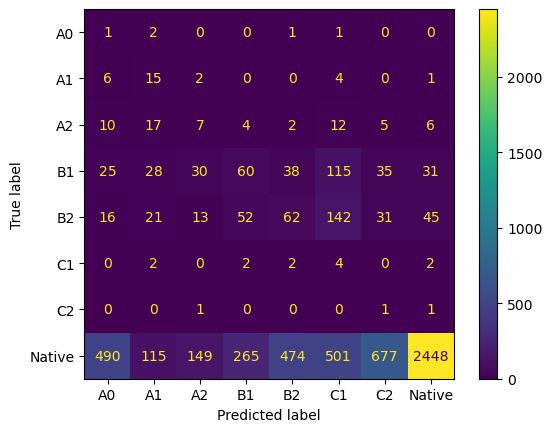

In [52]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.savefig('confusion_logreg.png')

### Experiment 2: delete A0 and C2

In [53]:
X = for_clf[~for_clf['level'].isin({'A0', 'C2'})].drop(columns=['level'])
y = for_clf[~for_clf['level'].isin({'A0', 'C2'})]['level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.06      0.68      0.11        28
          A2       0.03      0.25      0.05        63
          B1       0.17      0.15      0.16       362
          B2       0.18      0.29      0.22       382
          C1       0.00      0.33      0.01        12
      Native       0.96      0.61      0.75      5119

    accuracy                           0.56      5966
   macro avg       0.23      0.39      0.22      5966
weighted avg       0.85      0.56      0.67      5966



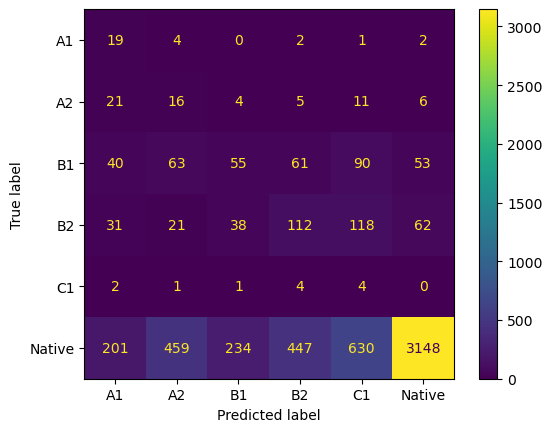

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.savefig('confusion_best.png')

In [55]:
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.12      0.14      0.13        28
          A2       0.17      0.14      0.16        63
          B1       0.23      0.26      0.24       362
          B2       0.25      0.27      0.26       382
          C1       0.00      0.00      0.00        12
      Native       0.91      0.89      0.90      5119

    accuracy                           0.80      5966
   macro avg       0.28      0.29      0.28      5966
weighted avg       0.81      0.80      0.80      5966



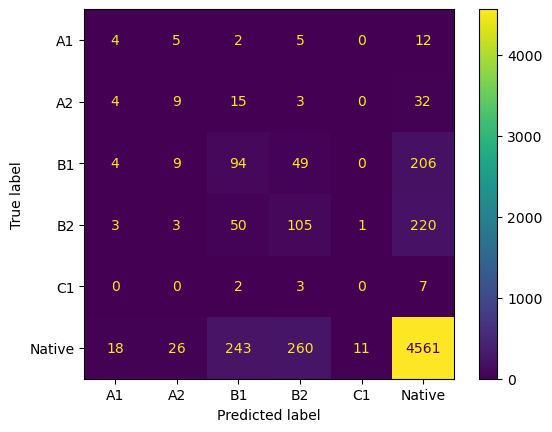

In [56]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.savefig('confusion_tree.png')

### Feature Importance

In [78]:
fimp = pd.DataFrame({'Feature': X_train.columns,
                     'Importance': clf.feature_importances_})
fimp.set_index('Feature', inplace=True)
fimp.sort_values('Importance', inplace=True, ascending=False)

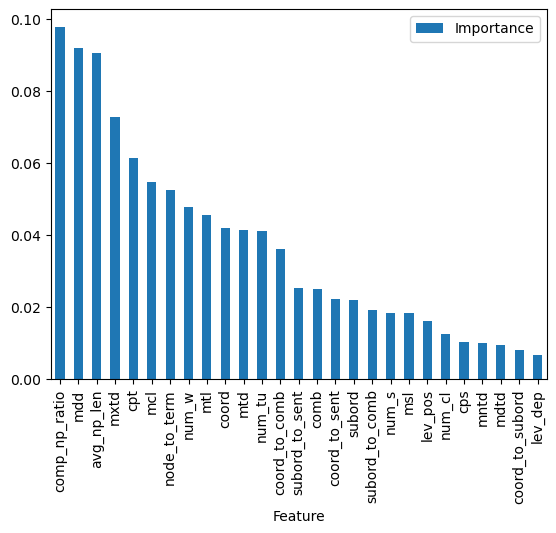

In [81]:
fimp.plot.bar()
plt.savefig('importance.png', bbox_inches='tight')

In [121]:
X = for_clf[~for_clf['level'].isin({'A0', 'C2'})].drop(columns=['level'])[['comp_np_ratio', 'mdd', 'avg_np_len', 'mxtd', 'cpt', 'mcl', 'node_to_term', 'num_w', 'mtl', 'num_tu', 'coord_to_comb']]
y = for_clf[~for_clf['level'].isin({'A0', 'C2'})]['level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A1       0.09      0.14      0.11        28
          A2       0.09      0.22      0.13        63
          B1       0.18      0.34      0.24       362
          B2       0.19      0.37      0.26       382
          C1       0.02      0.08      0.03        12
      Native       0.93      0.78      0.85      5119

    accuracy                           0.72      5966
   macro avg       0.25      0.32      0.27      5966
weighted avg       0.82      0.72      0.76      5966



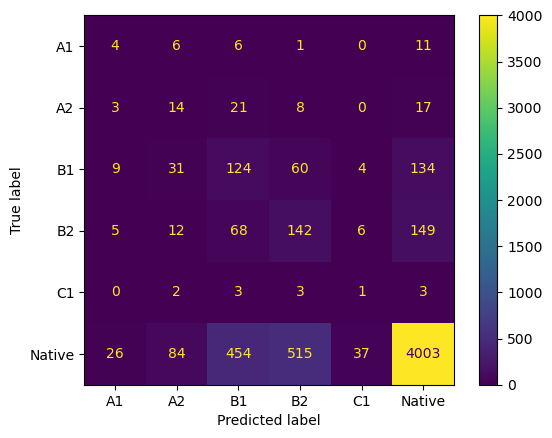

In [122]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

### Experiment 3: grid-search

In [27]:
model = LogisticRegression(random_state=42, solver='saga')

params = {'penalty': ['l1', 'l2'],
          'class_weight': ['balanced', None],
          'fit_intercept': [True, False]}

grid_search = GridSearchCV(model,
                           param_grid=params,
                           refit=False,
                           scoring='f1_weighted',
                           n_jobs=None,
                           verbose=3)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.416 total time=   9.3s
[CV 2/5] END class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.425 total time=   8.9s
[CV 3/5] END class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.421 total time=   8.9s
[CV 4/5] END class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.425 total time=   9.3s
[CV 5/5] END class_weight=balanced, fit_intercept=True, penalty=l1;, score=0.419 total time=   9.8s
[CV 1/5] END class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.416 total time=   6.3s
[CV 2/5] END class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.425 total time=   5.9s
[CV 3/5] END class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.421 total time=   6.0s
[CV 4/5] END class_weight=balanced, fit_intercept=True, penalty=l2;, score=0.425 total time=   6.3s
[CV 5/5] END class_weight=balanced, fit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super()._

In [36]:
model = LogisticRegression(random_state=42, class_weight='balanced', fit_intercept=True, penalty='l2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A0       0.00      0.20      0.00         5
          A1       0.07      0.57      0.12        28
          A2       0.03      0.08      0.04        63
          B1       0.16      0.17      0.16       362
          B2       0.12      0.20      0.15       382
          C1       0.00      0.25      0.01        12
          C2       0.00      0.33      0.00         3
      Native       0.97      0.47      0.63      5119

    accuracy                           0.43      5974
   macro avg       0.17      0.28      0.14      5974
weighted avg       0.84      0.43      0.56      5974



### Experiment 4: add clause percentages

In [29]:
levels_for_clf = levels.copy()
levels_for_clf = levels_for_clf[~levels_for_clf['level'].isin({'A0', 'C2'})]

for_clf = levels[['level',
                  'num_s', 'num_w', 'num_cl', 'num_tu',
                  'msl', 'mcl', 'mtl', 'cps', 'cpt',
                  'lev_pos', 'lev_dep', 'mtd', 'mdtd', 'mxtd', 'mntd', 'mdd',
                  'node_to_term',  'comb', 'coord', 'subord',
                  'coord_to_comb', 'subord_to_comb', 'coord_to_sent',
                  'subord_to_sent', 'avg_np_len', 'comp_np_ratio', 'coord_to_subord',
                  'clause_percentage']]
for_clf.fillna(0, inplace=True)

In [33]:
recs = for_clf.to_dict(orient='records')
for rec in recs:
    clausep = ast.literal_eval(rec['clause_percentage'])
    for deprel in clausep:
        rec[deprel] = clausep[deprel]
for_clf = pd.DataFrame(recs)
for_clf.drop(columns=['clause_percentage'], inplace=True)

In [35]:
X = for_clf.drop(columns=['level'])
y = for_clf['level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A0       0.00      0.20      0.00         5
          A1       0.07      0.57      0.12        28
          A2       0.03      0.08      0.04        63
          B1       0.16      0.17      0.16       362
          B2       0.12      0.20      0.15       382
          C1       0.00      0.25      0.01        12
          C2       0.00      0.33      0.00         3
      Native       0.97      0.47      0.63      5119

    accuracy                           0.43      5974
   macro avg       0.17      0.28      0.14      5974
weighted avg       0.84      0.43      0.56      5974



## Regression

In [82]:
realec = data[data['corpus'] == 'realec']
realec['mark'].value_counts()

mark
60.0    946
65.0    523
55.0    505
50.0    215
70.0    138
45.0     51
40.0     38
75.0     30
30.0     12
35.0     10
20.0      9
25.0      7
80.0      3
69.0      2
85.0      1
Name: count, dtype: int64

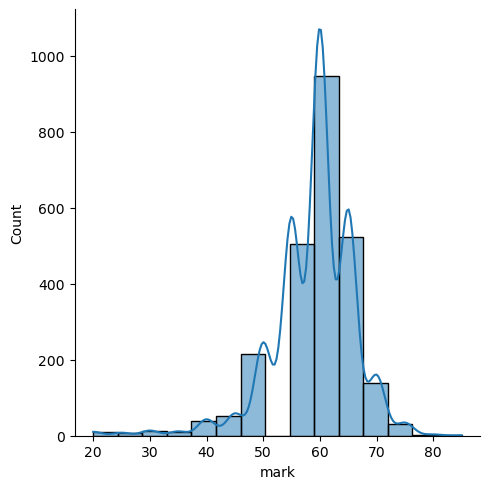

In [90]:
sns.displot(data=realec, x='mark', kde=True, bins=15)
plt.savefig('marks.png')

In [94]:
for_reg = realec[['mark',
                  'num_s', 'num_w', 'num_cl', 'num_tu',
                  'msl', 'mcl', 'mtl', 'cps', 'cpt',
                  'lev_pos', 'lev_dep', 'mtd', 'mdtd', 'mxtd', 'mntd', 'mdd',
                  'node_to_term',
                  'comb', 'coord', 'subord', 'coord_to_comb', 'subord_to_comb',
                  'coord_to_sent', 'subord_to_sent', 'avg_np_len', 'comp_np_ratio', 'coord_to_subord']]
for_reg.fillna(0, inplace=True)
X = for_reg.drop(columns=['mark'])
y = for_reg['mark']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

LinearRegression()

In [99]:
mean_squared_error(y_pred, y_test, squared=False)

7.001396045730047

In [104]:
mean_absolute_error(y_pred, y_test)

5.02536367068667

In [101]:
r2_score(y_test, y_pred)

0.15192584561080635

In [109]:
ridge_model = Ridge(random_state=42)

ridge_params = {'alpha': [0.05, 0.1, 0.15, 0.5, 1, 2, 3, 5],
                'fit_intercept': [True, False],
                'positive': [True, False],
                'solver': ['auto', 'svd', 'cholesky',
                           'lsqr', 'sparse_cg', 'saga']}

grid_search = GridSearchCV(ridge_model,
                           param_grid=ridge_params,
                           refit=False,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best score: -4.8323295844663985
Best parameters: {'alpha': 3, 'fit_intercept': True, 'positive': False, 'solver': 'sparse_cg'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1134, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 832, in fit
    raise ValueError(
ValueError: solver='svd' 

In [111]:
reg = Ridge(alpha=3, fit_intercept=True, positive=False, solver='sparse_cg', random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test), r2_score(y_test, y_pred)

(6.991018442189318, 5.009399691591254, 0.15443804597805122)

In [115]:
model = ElasticNet(random_state=42)

params = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.15, 0.5, 1, 2, 3, 5],
          'l1_ratio': [0.25, 0.5, 0.75],
                'fit_intercept': [True, False],
                'positive': [True, False],
                'selection': ['cyclic', 'random']}

grid_search = GridSearchCV(model,
                           param_grid=params,
                           refit=False,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best score: -4.811819997775502
Best parameters: {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.5, 'positive': True, 'selection': 'random'}


In [116]:
reg = ElasticNet(alpha=0.001, fit_intercept=True, positive=False, selection='random', l1_ratio=0.5, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test), r2_score(y_test, y_pred)

(6.9783719283164745, 4.9985562026526615, 0.1574944644562446)